## Step 1: make lists of cars and not cars images

In [4]:
import os
import glob
# images are divided in vehicles and non-vehicles
basedir = 'vehicles'
# a folder per image source
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    if imtype[0] != '=':
        cars.extend(glob.glob(os.path.join(basedir,imtype,'*')))  ## os.join

print('Number of Vehicle Images found:', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

# Idem for non-vehicles
basedir = 'non-vehicles'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    if imtype[0] != '=':
        notcars.extend(glob.glob(os.path.join(basedir,imtype,'*')))  

print('Number of Non-Vehicle Images found:', len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')


Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 9014


## Step 2 : Define feature extracting functions
The operational software is integrated in `classes/RoadImage.py` as method `find_cars()` and differs significantly from the functions below. Those functions are copied directly from the classroom.

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split


# Def a function to return HOG features and visualisation
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis = True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                   transform_sqrt=False,
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=False, feature_vector=feature_vec)
        return features

# Def a func to compute binned color features
def bin_spatial(img, size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))     # dimshuffle...

# Def a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# He opted for automatic bin range
def color_hist(img, nbins=32):   # bins_range=(0,256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate([channel1_hist[0], 
                                    channel2_hist[0], 
                                    channel3_hist[0]])
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def feature_length(img_size=(64,64,3), spatial_size=(32,32),
                     hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    if hog_channel=='ALL': hog_channel=img_size[2]
    else:                  hog_channel=1
        
    nxblocks = (img_size[0] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_size[1] // pix_per_cell) - cell_per_block + 1 
    if hog_feat==True: nfeat_per_block = orient*cell_per_block**2
    else:              nfeat_per_block = 0
    if spatial_feat==False: spatial_size=(0,0)
    if hist_feat==False: hist_bins=0
    
    return img_size[2]*(spatial_size[0]*spatial_size[1]+hist_bins)\
        +hog_channel*nxblocks*nyblocks*nfeat_per_block
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, feat_array, color_space='RGB', spatial_size=(32,32),
                     hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Iterate through the list of images
    #import pdb; pdb.set_trace()
    for cnt,file in enumerate(imgs):
        try:
            file_features = []
            # Read in each one by one
            image = None
            image = mpimg.imread(file)
            
            # apply color conversion if other than 'RGB'
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCC':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                else:
                    raise ValueError('Invalid colorspace code')
            else: feature_image = np.copy(image)

            if spatial_feat == True:
                spatial_features = bin_spatial(feature_image, size=spatial_size)
                file_features.append(spatial_features)
            if hist_feat == True:
                # Apply color_hist()
                hist_features = color_hist(feature_image, nbins=hist_bins)
                file_features.append(hist_features)
            if hog_feat == True:
                # Call get_hot_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True))
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features_list
                file_features.append(np.ravel(hog_features))
            feat_array[cnt,:]=np.concatenate(file_features)
        except Exception as e: # recover from ANY exception
            print('Bad file:',file,'\n%s'%str(e))
            if isinstance(image,np.ndarray):
                print('shape:', image.shape, ' dtype:', image.dtype)
        # Clean up
        del image
        # Display progress
        if (cnt+1) % 1000 == 0:
            print(cnt+1,'images processed.')
    # Return list of feature vectors
    return None



## Step 3 : Explore the data set and HOG parameters
The next cell calls `get_hog_features()` on select images I have copied from the data sets, and stored in the `examples` folder. The corresponding files are numbered PNG files.

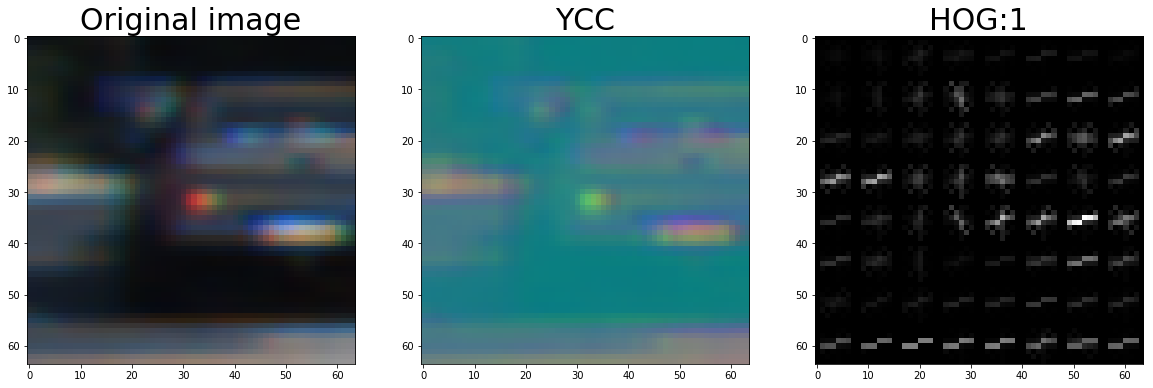

In [4]:
from classes import RoadImage
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Vehicles
file='9.png'
file='46.png'
#file='310.png'
# Non-vehicles
#file='test1-015.jpg'
#file='test5-003.jpg'
#file='test5-008.jpg'

image = RoadImage(filename='examples/'+file, src_cspace = 'RGB')

orient = 9              # HOG orientations
pix_per_cell = 8        # HOG pixels per cell
cell_per_block = 2      # HOG cells per block
cspace = 'YCC'

conv = image.convert_color(cspace).to_float().astype(np.float64)

hog_channel=1

_, hogimg = get_hog_features(conv[:,:,hog_channel],
                          orient, pix_per_cell, cell_per_block,
                          vis=True, feature_vec=False)

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
image.show(ax1,title = 'Original image')
conv.show(ax2,title = cspace)
RoadImage(hogimg.astype(np.float32), src_cspace='GRAY').normalize().show(ax3,title = 'HOG:'+str(hog_channel))

## Step 4 : Make feature vector X
The next code cell reads back the image lists, reads all the images one by one, without keeping them in memory, and extract the feature vector. At line 45, the whole vector X is allocated as a single block to limit the additional memory requirement which occur as a consequence of copying large lists. In the classroom implementation two separate feature vectors for cars and not-cars were concatenated: an operation which requires two times the amount of memory required to hold the combined list.

`train_test_split()` does nothing to conserve memory. It leaves intact the source data and generates two lists. It would be possible to reimplement it so that the function reorders the vectors in place, rather than copying them. Allocating 4 GB of RAM allowed the use of 10,000 cars and 10,000 not-cars to train the classifier. The source X and y vectors are deleted immediately after calling `train_test_split()` at line 85.

The Support Vector Machine algorithm also needs hundreds of megabytes of RAM to run `svc.fit(X)`, and requires to have the whole feature set and labels in memory. By comparison, the scaler can operate on batches of feature vectors using `fit_partial()` and uses little memory.

Each feature vector is 8460 times size(np.float32) bytes long, therefore the storage space for 18675 feature vectors (one per image) should not exceed 603 MB. In practice, this is roughly verified for the python process, which globally reaches 1 GB just before `train_test_split()`, twice that immediately after, and again twice that when fitting the classifier. 

In [6]:
import pdb
%pdb

import pickle


def read_image_list_from_file(filename, *, step=1):
    list = []
    with open(filename, 'r') as f:
        cnt = step
        for line in f:
            if cnt==step:
                if line[-1]=='\n': line = line[:-1]
                list.append(line)
            cnt -= 1
            if cnt==0: cnt = step
    return list

car_list = read_image_list_from_file('cars.txt',step=1)  # 4 with Udacity vehicles
notcar_list = read_image_list_from_file('notcars.txt',step=1)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
orient = 9             # HOG orientations
pix_per_cell = 8        # HOG pixels per cell
cell_per_block = 2      # HOG cells per block
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32          # Number of histogram bins
cspace = 'YCC'
hog_channel='ALL'
hog_feat=True

feat_len = feature_length(img_size=(64,64,3), 
                 spatial_size=spatial_size,
                 hist_bins=hist_bins, orient=orient,
                 hog_channel=hog_channel,
                 pix_per_cell=pix_per_cell, 
                 cell_per_block=cell_per_block, 
                 spatial_feat=True, hist_feat=True, 
                 hog_feat=hog_feat)

nb_car = len(car_list)
nb_notcar =len(notcar_list)

X = np.empty(shape=(nb_car+nb_notcar,feat_len),dtype=np.float32)

extract_features(car_list, X[:len(car_list)],
                 color_space=cspace, 
                 spatial_size=spatial_size,
                 hist_bins=hist_bins, orient=orient,
                 hog_channel=hog_channel,
                 pix_per_cell=pix_per_cell, 
                 cell_per_block=cell_per_block, 
                 spatial_feat=True, hist_feat=True, 
                 hog_feat=hog_feat)

extract_features(notcar_list, X[len(car_list):],
                 color_space=cspace, 
                 spatial_size=spatial_size,
                 hist_bins=hist_bins, orient=orient,
                 hog_channel=hog_channel,
                 pix_per_cell=pix_per_cell, 
                 cell_per_block=cell_per_block, 
                 spatial_feat=True, hist_feat=True,
                 hog_feat=hog_feat)


# Fit a per-column scaler
X_scaler = StandardScaler()
X_scaler.fit(X)
X=X_scaler.transform(X, copy=False)

# Apply the scaler to X
#X_scaler.transform(X, copy=False)

# Define the labels vector
y = np.zeros(shape=(nb_car+nb_notcar,),dtype=np.uint8)
y[:nb_car]=1

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Clean up
del X
del y

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

dict_pickle = { 'svm':svc, 'scaler':X_scaler }
pickle.dump( dict_pickle, open('trained_svc.p','wb'))

Automatic pdb calling has been turned OFF
1000 images processed.
2000 images processed.
3000 images processed.
4000 images processed.
5000 images processed.
6000 images processed.
7000 images processed.
8000 images processed.
1000 images processed.
2000 images processed.
3000 images processed.
4000 images processed.
5000 images processed.
6000 images processed.
7000 images processed.
8000 images processed.
9000 images processed.
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 8460
44.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9876
My SVC predicts:  [0 1 1 0 0 0 0 1 0 1]
For these 10 labels:  [0 1 1 0 0 0 0 1 0 1]
0.00267 Seconds to predict 10 labels with SVC


## Step 5 : Extracting vehicles from the 2nd Udacity data set
I finally stopped using it, because this dataset also has time series issues. While KITTI is clearly a set of European images, it is interesting to note that training is better with this mix of KITTI and GTI images, rather than the Udacity data set which show US roads.

The typical road scenes in KITTI are very different from the highway scene in the project video. The KITTI database shows urban scenes with scores of parked cars everywhere. On the contrary, the project video shows very light traffic on a highway in relatively open space. 

In [1]:
import matplotlib.image as mpimg
import cv2
import os
#import pdb
#%pdb

# The Udacity data set is massive and the process of fitting a classifer requires
# that the whole set of feature vectors be present in memory at the same time.
# The memory requirement limits the data set to less than 10000 vehicles and 10000 non-vehicles.
# We use the supplied non-vehicles, completed by hard negative mining from the first runs.

# Extract non occluded vehicle images from Udacity data set
with open('object-dataset/labels.csv') as f:
    current_filename = None
    counter = 0
    for imgdat in f:
        filename, x1, y1, x2, y2, occluded, label = tuple(imgdat.split(' ',6))
        if filename != current_filename:
            img = mpimg.imread(os.path.join('object-dataset',filename))
            current_filename = filename
            object_cntr = 1
            height, width  = img.shape[:2]
            #print(img.dtype, np.min(img), np.max(img))
        
        counter += 1
        if counter % 1000 == 0: print('thousand')
        
        # Eliminate occluded and non vehicles
        if int(occluded): continue
        if not(('car' in label) or ('truck' in label)): continue
            
        # Convert strings to int
        x1 = int(x1)
        x2 = int(x2)
        y1 = int(y1)
        y2 = int(y2)
        # Keep aspect ratio
        xspan = x2-x1
        yspan = y2-y1
        if xspan > yspan:
            delta_y = (xspan - yspan)//2
            delta_x = 0
        else:
            delta_x = (yspan - xspan)//2
            delta_y = 0
        
        x1 -= delta_x
        x2 += delta_x
        y1 -= delta_y
        y2 += delta_y
        
        if x1<0:
            x2 -= x1
            x1 = 0
        if x2>width:
            x1 -= (x2-width)
            x2 = width
        if y1<0:
            y2 -= y1
            y1 = 0
        if y2>height:
            y1 -= (y2-height)
            y2 = height
            
        # Resize
        crop = img[y1:y2,x1:x2]
        crop = cv2.resize(crop, (64,64))
        
        root, ext = os.path.splitext(filename)
        outf = os.path.join('Udacity2',root+('-%02d'%object_cntr)+ext)
        outf = os.path.join('vehicles',outf)
        mpimg.imsave(outf, crop, vmin=0, vmax=255, format='jpg')
        object_cntr += 1


thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand
thousand


## Step 6 : Prototyping detection in single images
The final code is not that one. This is mainly copy paste of the classroom functions. The final source code is in the `find_cars()` method in `classes/RoadImage.py`.

In [ ]:
# Def a func that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None,None], y_start_stop=[None, None],
                 xy_window=(64,64), xy_overlap=(0.5,0.5)):    # Init None
    # Default params
    if x_start_stop[0] is None: x_start_stop[0] = 0
    if x_start_stop[1] is None: x_start_stop[1] = img.shape[1]

    if y_start_stop[0] is None: y_start_stop[0] = 0
    if y_start_stop[1] is None: y_start_stop[1] = img.shape[0]
    # spans
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # pixels per step
    nx_pix_per_step = int(xy_window[0] * xy_overlap[0])
    ny_pix_per_step = int(xy_window[1] * xy_overlap[1])
    # Number of windows
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Draw boxes in color on a copy of the image, and return the copy.
    """
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bb in bboxes:
        cv2.rectangle(draw_img, bb[0], bb[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes


In [11]:
import pickle
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
from pathlib import Path
import os
import numpy as np
from classes import CameraCalibration, RoadImage

# Define a function which takes a heatmap, adds val to each pixel contained
# in each box (so multiple times in some cases), get a derived map with a threshold
# and using scipy's label function, return individual boxes for each object.
def apply_heat(heatmap, bboxes, val, doboxes=True):
    for ix,bb in enumerate(bboxes):
        x1,y1 = bb[0]
        x2,y2 = bb[1]
        heatmap[y1:y2,x1:x2] += val
    if doboxes==True:
        binmap = heatmap.normalize(inplace=False)
        binmap.threshold(mini=0.2, inplace=True)
        binmap = np.squeeze(binmap.view(np.ndarray))
        nb_label = label(binmap, output=binmap)
        draw_boxes = []
        for n,_ in enumerate(range(nb_label),1):
            area = (binmap==n)
            sumx = np.sum(area, axis=0)
            sumy = np.sum(area, axis=1)
            x1 = np.argmax(sumx)
            x2 = np.argmin(sumx[x1:])+x1
            y1 = np.argmax(sumy)
            y2 = np.argmin(sumy[y1:])+y1
            draw_boxes.append(((x1,y1),(x2,y2)))
    return draw_boxes

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
#def draw_boxes(fname, img, bboxes, color=(0, 0, 255), thick=6):
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Draw boxes in color on a copy of the image, and return the copy.
    """
    # make a copy of the image
    draw_img = np.copy(img)
    # save detected images to disk
    for ix,bb in enumerate(bboxes):
        #x1,y1 = bb[0]
        #x2,y2 = bb[1]
        #subimg  = cv2.resize(img[y1:y2,x1:x2], (64,64))
        #filename='%s-%03d.jpg' % (fname,ix)
        #mpimg.imsave(os.path.join('output_images',filename), subimg, vmin=0, vmax=255, format='jpg')
        # draw each bounding box on your image copy using cv2.rectangle()
        cv2.rectangle(draw_img, bb[0], bb[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img 

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_at_scale(img, area, scale, svc, X_scaler, cspace, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    #draw_img = img.copy()
    xstart,ystart = area[0]
    xstop, ystop  = area[1]
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:].to_float()
    ctrans_tosearch = img_tosearch.convert_color(cspace).copy() #'HSV'/ YCC'
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = ctrans_tosearch.resize((int(round(float(imshape[1]/scale))), int(round(float(imshape[0]/scale)))))
        
    ch1 = ctrans_tosearch.view(np.ndarray)[:,:,0]
    ch2 = ctrans_tosearch.view(np.ndarray)[:,:,1]
    ch3 = ctrans_tosearch.view(np.ndarray)[:,:,2]

    # Define blocks and steps as above
    width, height = ctrans_tosearch.get_size()
    #nxblocks = (width // pix_per_cell) - cell_per_block + 1
    #nyblocks = (height // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    #nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    #nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    ncells_per_window = window // pix_per_cell
    nxcells = width // pix_per_cell
    nycells = height // pix_per_cell
    nxsteps = (nxcells - ncells_per_window) // cell_per_block + 1
    nysteps = (nycells - ncells_per_window) // cell_per_block + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    #print(nxsteps*nysteps,'windows at scale %4.2f.'%scale)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Test patch in map
            #[ytop:ytop+window, xleft:xleft+window]
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg  = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xleft_draw = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xleft_draw+xstart, ytop_draw+ystart),(xleft_draw+win_draw+xstart,ytop_draw+win_draw+ystart)))
    return bboxes            

def find_cars_in_image(image, clf, scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """
    Find cars in road image at all scales and return their bounding boxes.
    """
    img = image.convert_color(cspace) # Do color conversion once for all scales
    
    heatmap = np.zeros_like(img.channel(0), dtype=np.float32)
    bboxes = []
    
    # 256x256
    area = ((0,336),(1280,656))
    bb = find_at_scale(img, area, 4., clf, scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bb)
    
    # 128x128
    area = ((0,400),(1280,592))
    bb = find_at_scale(img, area, 2., clf, scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bb)
    
    # 96x96
    area = ((200,400),(1080,544))
    bb = find_at_scale(img, area, 1.5, clf, scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bb)
    
    # 64x64
    area = ((340,400),(940,496))
    bb = find_at_scale(img, area, 1., clf, scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bb)
    
    # Those scales would only be tested locally around targets found at scale 1 previously
    # 32x32
    area = ((400,400),(880,448))
    #bb = find_at_scale(img, area, 0.5, clf, scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes.extend(bb)
    
    # 20x20
    area = ((400,400),(880,435))
    #bb = find_at_scale(img, area, 0.3, clf, scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes.extend(bb)
    
    #img = draw_boxes(fname, img, bboxes)
    drwboxes = apply_heat(heatmap, bboxes, 1)
    image = draw_boxes(image, drwboxes)

    root, ext = os.path.splitext(str(file_in))
    fname = os.path.basename(root)
    ext = '.jpg'
    file_out = os.path.join('output_images',fname+ext)
    mpimg.imsave(file_out, image, vmin=0, vmax=255, format='jpg')
    
    file_out = os.path.join('output_images',fname+'_heatmap'+ext)
    mpimg.imsave(file_out, np.squeeze(heatmap.view(np.ndarray)), cmap='hot', format='jpg')
    return

cspace = 'YCC'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

# Images are 64x64
# Features are 3x(((64//8-1),(64//8-1),2,2,15)+32+15x15)=9591

dict_pickle = pickle.load(open('trained_svc.p','rb'))
clf = dict_pickle['svm']
scaler = dict_pickle['scaler']

ystart = 400
ystop = 656
scale = 1.5

cal = CameraCalibration('validation.p')

testimg = Path('test_images')
files = list(testimg.glob('*.jpg'))

print(files)

import pdb
#%pdb

# Record to hold tunables
class State(object):
    pass

for file_in in files:
    #img = mpimg.imread(str(file_in))
    img = RoadImage(filename=str(file_in), src_cspace='RGB')
    #print('min:',np.min(img),' max:',np.max(img))
    img = img.undistort(cal)
    RoadImage.find_cars.state = State() # Each image is independent
    RoadImage.find_cars.state.new_car = 1     # Show cars with no delay
    RoadImage.find_cars.state.draw_boxes = True # And show post-heatmap boxes
    img, heatmap = img.find_cars('trained_svc.p', vis_heatmap=True)

    root, ext = os.path.splitext(str(file_in))
    fname = os.path.basename(root)
    ext = '.jpg'
    file_out = os.path.join('output_images',fname+ext)
    mpimg.imsave(file_out, img, vmin=0, vmax=255, format='jpg')
    
    file_out = os.path.join('output_images',fname+'_heatmap'+ext)
    mpimg.imsave(file_out, np.squeeze(heatmap.view(np.ndarray)), cmap='hot', format='jpg')


[PosixPath('test_images/test3.jpg'), PosixPath('test_images/test1.jpg'), PosixPath('test_images/test2.jpg'), PosixPath('test_images/test4.jpg'), PosixPath('test_images/test6.jpg'), PosixPath('test_images/test5.jpg')]
Initialisation of RoadImage.find_cars().
Using static state record.
    draw_boxes = True
    new_car = 1
New car at 920,448, scale 1.50
Initialisation of RoadImage.find_cars().
Using static state record.
    draw_boxes = True
    new_car = 1
New car at 896,464, scale 2.00
New car at 1168,464, scale 2.00
Initialisation of RoadImage.find_cars().
Using static state record.
    draw_boxes = True
    new_car = 1
Initialisation of RoadImage.find_cars().
Using static state record.
    draw_boxes = True
    new_car = 1
New car at 880,464, scale 2.00
New car at 1168,464, scale 2.00
Initialisation of RoadImage.find_cars().
Using static state record.
    draw_boxes = True
    new_car = 1
New car at 960,464, scale 4.00
New car at 1168,464, scale 2.00
Initialisation of RoadImage.find_

In [1]:
from classes import CameraCalibration, RoadImage
from classes.decorators import static_vars
import pdb
%pdb

cal = CameraCalibration('validation.p')
# Set the camera harmonization parameters for our car.
cal.camera_height=1.2
cal.set_ahead(638,418)

# Record to hold tunables
class State(object):
    pass

# Tunables
RoadImage.find_cars.state = State()
RoadImage.find_cars.state.colorspace = 'YCC'         # Colorspace for feature vector extraction
RoadImage.find_cars.state.nb_orient = 9              # Nb of gradient orientations in HOG
RoadImage.find_cars.state.pix_per_cell = 8           # HOG pixels per cell
RoadImage.find_cars.state.cell_per_block = 2         # HOG cells per block
RoadImage.find_cars.state.spatial_size = (32, 32)    # Spatial binning dimensions
RoadImage.find_cars.state.hist_bins = 32             # Number of histogram bins
RoadImage.find_cars.state.track = None               # None to disable
RoadImage.find_cars.state.queue_depth = 10
RoadImage.find_cars.state.stop_tracking = 10
RoadImage.find_cars.state.new_car = 25
RoadImage.find_cars.state.recent = 1
RoadImage.find_cars.state.draw_boxes = False
RoadImage.find_cars.state.scan_scales = [1,2,3]
RoadImage.find_cars.state.scales = [2., 1.5, 1., 0.5]
RoadImage.find_cars.state.areas = [
    ((  0,400),(1280,592)),
    ((640,400),(1280,656)),
    #(( 200,400),(1080,544)), 
    ((340,424),( 940,520)),
    ((400,424),( 880,472)), 
]

def process_image(image):
    img = RoadImage(image, src_cspace='RGB')
    img = img.undistort(cal)

    # Get car bounding boxes
    img = img.find_cars('trained_svc.p')

    return img    

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

file = 'project_video.mp4'
#file = 'challenge_video.mp4'
#file = 'test_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(file).subclip(37,42)
#clip1 = VideoFileClip(file).subclip(20,25)
#clip1 = VideoFileClip(file).subclip(33,43)
#clip1 = VideoFileClip(file).subclip(0,10)

clip1 = VideoFileClip(file)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
clip.write_videofile('output_images/'+file, audio=False)

Automatic pdb calling has been turned ON
Initialisation of RoadImage.find_cars().
Using static state record.
    new_car = 25
    draw_boxes = False
    recent = 1
    stop_tracking = 10
    colorspace = YCC
    hist_bins = 32
    areas = [((0, 400), (1280, 592)), ((640, 400), (1280, 656)), ((340, 424), (940, 520)), ((400, 424), (880, 472))]
    spatial_size = (32, 32)
    cell_per_block = 2
    scales = [2.0, 1.5, 1.0, 0.5]
    queue_depth = 10
    pix_per_cell = 8
    nb_orient = 9
    track = None
    scan_scales = [1, 2, 3]
[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


 12%|█▏        | 155/1261 [04:11<29:56,  1.62s/it]

New car at 1153,484, scale 1.50


 18%|█▊        | 226/1261 [06:06<28:08,  1.63s/it]

New car at 768,448, scale 0.50


 20%|█▉        | 249/1261 [06:43<26:52,  1.59s/it]

Car gone at 768,448, scale 0.50, seen 38 times


 57%|█████▋    | 722/1261 [19:23<14:06,  1.57s/it]

New car at 1180,580, scale 1.50


 59%|█████▉    | 745/1261 [20:00<13:59,  1.63s/it]

Car gone at 904,448, scale 1.50, seen 600 times


 75%|███████▍  | 940/1261 [25:11<08:20,  1.56s/it]

Car gone at 954,460, scale 1.50, seen 233 times


 76%|███████▌  | 955/1261 [25:34<07:45,  1.52s/it]

New car at 873,460, scale 1.50
New car at 1086,460, scale 1.50


 82%|████████▏ | 1034/1261 [27:36<05:55,  1.57s/it]

Car gone at 1135,448, scale 1.50, seen 94 times


 93%|█████████▎| 1174/1261 [31:11<02:11,  1.51s/it]

New car at 1192,472, scale 1.50


 95%|█████████▌| 1200/1261 [31:50<01:33,  1.54s/it]

Car gone at 1216,472, scale 1.50, seen 41 times


100%|█████████▉| 1260/1261 [33:22<00:01,  1.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

